In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def J_univariante(X,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))[:fases]
    ff2 = np.angle(np.fft.rfft(y1))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [92]:
monte = pd.read_csv('monte.txt', header=None).squeeze()
print(monte)
monte_j = J_univariante(monte, int(len(monte)/2), len(monte))
monte_j

0      74
1      70
2      67
3      55
4      74
       ..
650    70
651    67
652    55
653    62
654    55
Name: 0, Length: 655, dtype: int64


0.9528773867085727

In [91]:
with open('monte.txt', 'r') as file:
    data = file.readlines()
# print(data)

# Convertir los datos a un array de numpy
monte = np.array([int(line.strip()) for line in data])
print(monte)
monte_j = J_univariante(monte, int(len(monte)/2), len(monte))
monte_j

[74 70 67 55 74 69 66 62 79 70 67 63 75 72 67 60 74 74 67 59 75 72 67 60
 74 69 66 62 77 74 70 58 77 74 70 58 77 74 70 58 77 74 70 58 75 72 67 60
 74 69 66 62 74 71 67 55 79 70 67 77 76 74 74 76 69 65 67 64 77 65 62 76
 72 67 64 74 70 72 69 69 65 74 70 65 62 76 72 67 60 77 74 70 58 77 72 69
 65 70 70 72 69 67 69 74 74 70 58 70 67 62 55 69 65 62 62 70 67 62 55 70
 67 62 55 69 69 62 54 70 67 62 55 69 64 61 57 72 69 65 53 72 69 65 53 72
 69 65 53 69 72 65 53 70 62 55 67 69 65 61 57 64 69 66 62 50 74 67 62 55
 71 74 72 72 64 52 69 69 60 53 66 62 50 62 70 67 69 69 74 66 62 67 70 63
 72 69 67 66 62 70 67 69 74 65 67 59 69 72 64 60 57 62 62 54 67 70 55 69
 69 61 57 65 57 62 64 57 61 66 69 57 62 50 74 66 69 62 74 67 70 55 77 69
 72 53 77 70 74 58 75 67 72 60 74 66 69 62 74 66 69 62 69 65 72 67 63 77
 70 65 62 69 75 70 67 67 74 70 72 72 67 63 74 62 70 66 64 69 66 71 74 67
 55 72 69 65 60 53 74 69 69 65 50 76 73 69 64 57 76 73 69 64 57 76 73 69
 64 57 77 74 69 62 50 76 73 69 64 57 74 74 69 65 50

0.9528773867085727

In [14]:
import numpy as np

# Definimos dos vectores como arrays de NumPy
v1 = np.array([3, 6])
v2 = np.array([2, 7])

v1_norm=v1/np.linalg.norm(v1)
v2_norm=v2/np.linalg.norm(v2)
angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
# Calculamos el producto punto entre los dos vectores
producto_punto = np.dot(v1, v2)
cruz=v1[0]*v2[1]-v1[1]*v2[0]
# Imprimimos el resultado
print("El producto punto entre v1 y v2 es:", producto_punto)
print(cruz)
print(angulo )
print(angulo+ np.pi)

El producto punto entre v1 y v2 es: 48
9
0.18534794999569484
3.326940603585488


In [4]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)

index0 = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas

data = pd.DataFrame(datos_composers)
print('Total Pieces = ',data.sum(axis=1)[1])
print(data)    

Total Pieces =  10061
           Dufay Morales Desprez Palestrina Lasso  Byrd Victoria Gabrielis  \
Birth_year  1397    1500    1521       1525  1532  1538     1548      1557   
# Piezas      13      88      35         61    70   109      326        23   

           Dowland Gesualdo  ...  Karg Respighi Medtner Bartok Stravinsky  \
Birth_year    1563     1566  ...  1877     1879    1880   1881       1882   
# Piezas        61       37  ...    12       12       7     17         37   

           Prokofiev Hindemith Gerswhin Shostakovich Messiaen  
Birth_year      1891      1895     1898         1906     1908  
# Piezas           6        20       12          109        9  

[2 rows x 77 columns]


C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_16708\2637987329.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',data.sum(axis=1)[1])


In [6]:
# for composer in data.columns:
#     if data[composer]['# Piezas'] == 2159:
#         print(data[composer])

Birth_year    1721
# Piezas      2159
Name: Bach, dtype: object


In [5]:
composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze() # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

Número total de elementos de todo el dataset:  8250485


In [93]:
composers['Bach']['Serie_1']

1       58 
2       58 
3       65 
4       65 
5       65 
       ... 
2069    66 
2070    65 
2071    65 
2072    63 
2073    63 
Name: 3080 , Length: 2073, dtype: object

In [24]:
Js = np.full((77,2160), np.nan)
for x, composer in enumerate(composers):
    for y, serie in enumerate(composers[composer]):
        f = composers[composer][serie]
        Js[x,y] = J_univariante(f, int(len(f)/2), len(f))
    print(composer)
np.save('J_composers.npy', Js)
#Se calculó la J para cada compositor de cada serie en el numpy array Js 

Dufay
Morales
Desprez
Palestrina
Lasso
Byrd
Victoria
Gabrielis
Dowland
Gesualdo
Monteverdi
Frescobaldi
Scheidt
Froberger
Anglebert
Lully
Buxtehude
Pachelbel
Couperin
Albinoni
Vivaldi
Telemann
Dandrieu
Rameau
Handel
Scarlatti
Zipoli
Bach
Haydn
Albrechtsberger
Clementi
Mozart
Beethoven
Cramer
Paganini
Schubert
Berlioz
Mendelssohn
Chopin
Schumann
Liszt
Alkan
Franck
Bruckner
Gottschalk
Brahms
Saint
Guiltmant
Bizet
Mussorgsky
Tchaikovsky
Dvorak
Grieg
Faure
Janacek
Albeniz
Mahler
Debussy
Busoni
Satie
Joplin
Godowsky
Scriabin
Rachmaninov
Reger
Schoenberg
Ravel
Karg
Respighi
Medtner
Bartok
Stravinsky
Prokofiev
Hindemith
Gerswhin
Shostakovich
Messiaen


In [25]:
Ns = np.full((77,2160), np.nan)
for x, composer in enumerate(composers):
    for y, serie in enumerate(composers[composer]):
        Ns[x,y] = len(composers[composer][serie])
np.save('Ns.npy', Ns)

#Se guardó la el tamaño de cada serie en Ns

In [42]:
composers.keys()

dict_keys(['Dufay', 'Morales', 'Desprez', 'Lasso', 'Byrd', 'Victoria', 'Gabrielis', 'Dowland', 'Gesualdo', 'Monteverdi', 'Frescobaldi', 'Scheidt', 'Froberger', 'Anglebert', 'Lully', 'Buxtehude', 'Pachelbel', 'Couperin', 'Albinoni', 'Vivaldi', 'Telemann', 'Dandrieu', 'Rameau', 'Handel', 'Scarlatti', 'Zipoli', 'Bach', 'Haydn', 'Albrechtsberger', 'Clementi', 'Mozart', 'Beethoven', 'Cramer', 'Paganini', 'Schubert', 'Berlioz', 'Mendelssohn', 'Chopin', 'Schumann', 'Liszt', 'Alkan', 'Franck', 'Bruckner', 'Gottschalk', 'Brahms', 'Saint', 'Guiltmant', 'Bizet', 'Mussorgsky', 'Tchaikovsky', 'Dvorak', 'Grieg', 'Faure', 'Janacek', 'Albeniz', 'Mahler', 'Debussy', 'Busoni', 'Satie', 'Joplin', 'Godowsky', 'Scriabin', 'Rachmaninov', 'Reger', 'Schoenberg', 'Ravel', 'Karg', 'Respighi', 'Medtner', 'Bartok', 'Stravinsky', 'Prokofiev', 'Hindemith', 'Gerswhin', 'Shostakovich', 'Messiaen'])

In [8]:
ToccataFugue = pd.read_csv('ToccataFugue.txt').squeeze()

Toccata_j = J_univariante(ToccataFugue, int(len(ToccataFugue)/2), len(ToccataFugue))
Toccata_j

0.9844547965667433

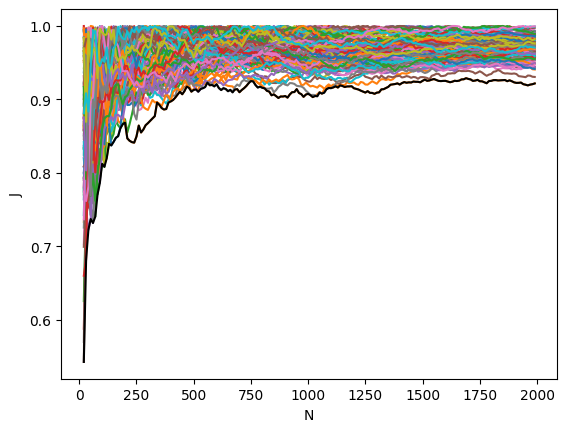

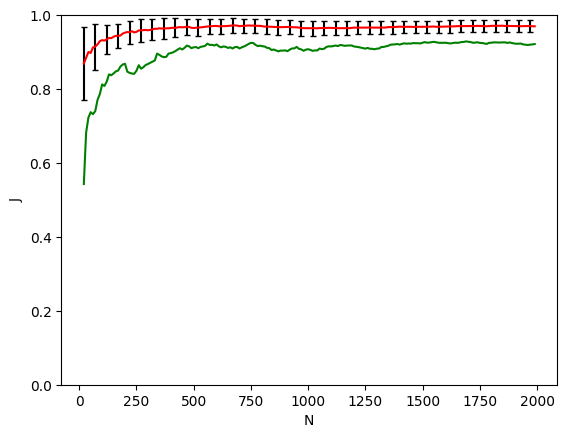

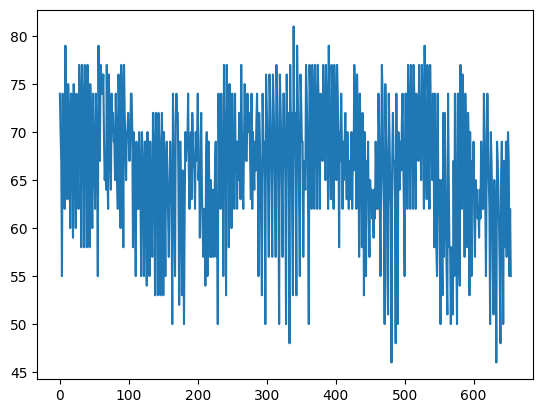

In [166]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

Ns = np.load('Ns.npy')
Js = np.load('J_composers.npy')
Jotas = np.load('Jotas.npy') #Jotas.npy contiene los 100 vectores de J hipotesis nula

x = range(20, 2000, 10)
J_mean = np.mean(Jotas, axis=0)
J_std = np.std(Jotas, axis = 0)

J_minus = np.min(Jotas, axis=0)

for i in range(100):
    plt.plot(x, Jotas[i,:])
plt.plot(x, J_minus, 'black')
plt.xlabel('N')
plt.ylabel('J')
plt.show()
fig, ax = plt.subplots()
ax.errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
ax.plot(x, J_mean, color = 'red')

ax.set_ylim(0, 1)
ax.set_xlabel('N')
ax.set_ylabel('J') 
# plt.scatter(len(canon), canon_j, marker ='.', color = 'green')
ax.plot(x, J_minus, 'green')
# plt.plot(Ns[0,:], Js[0,:], '.',color = 'blue')
with open('j_null.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.show()

plt.plot(monte)

A graficar


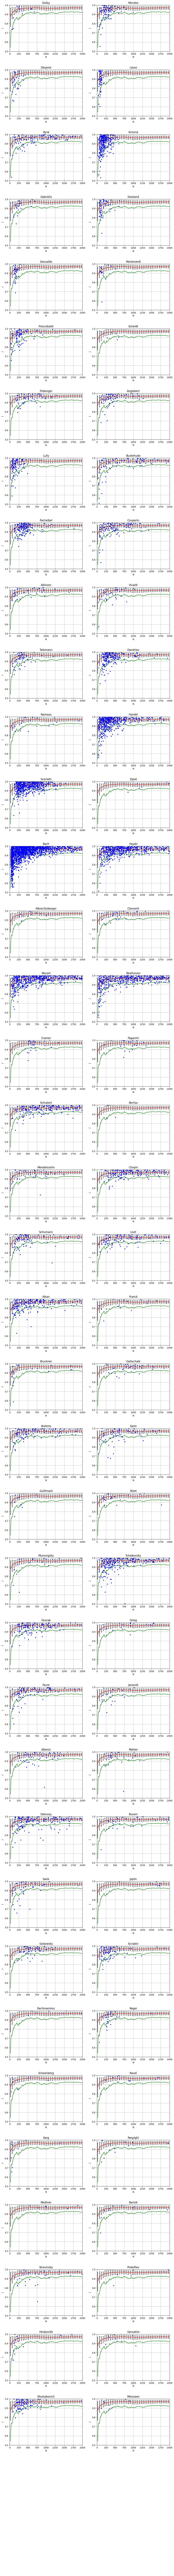

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Ns = np.load('Ns.npy')
Js = np.load('J_composers.npy')
Jotas = np.load('Jotas.npy')

x = range(20, 2000, 10)
J_mean = np.mean(Jotas, axis=0)
J_std = np.std(Jotas, axis = 0)

J_minus = np.min(Jotas, axis=0)

print('A graficar')
# Create a figure and subplots
fig, axs = plt.subplots(40, 2, figsize=(13, 210))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Plot data on each subplot
for i,composer in enumerate(composers):
        #Siempre
    axs[i].errorbar(x = x[::5], y = J_mean[::5], yerr= J_std[::5], fmt='none', ecolor = 'black', capsize=2)
    axs[i].plot(x, J_mean, color = 'red')
    axs[i].set_ylim(0.5, 1)
    axs[i].set_xlim(0, 2000)
    axs[i].set_xlabel('N')
    axs[i].set_ylabel('J') 
    axs[i].plot(x, J_minus, 'green')
    axs[i].grid()
    #for in
    axs[i].set_title(composer)
    axs[i].plot(Ns[i,:], Js[i,:], '.',color = 'blue')

# Hide any empty subplots
for j in range(76, 80):
    axs[j].axis('off')

plt.show()


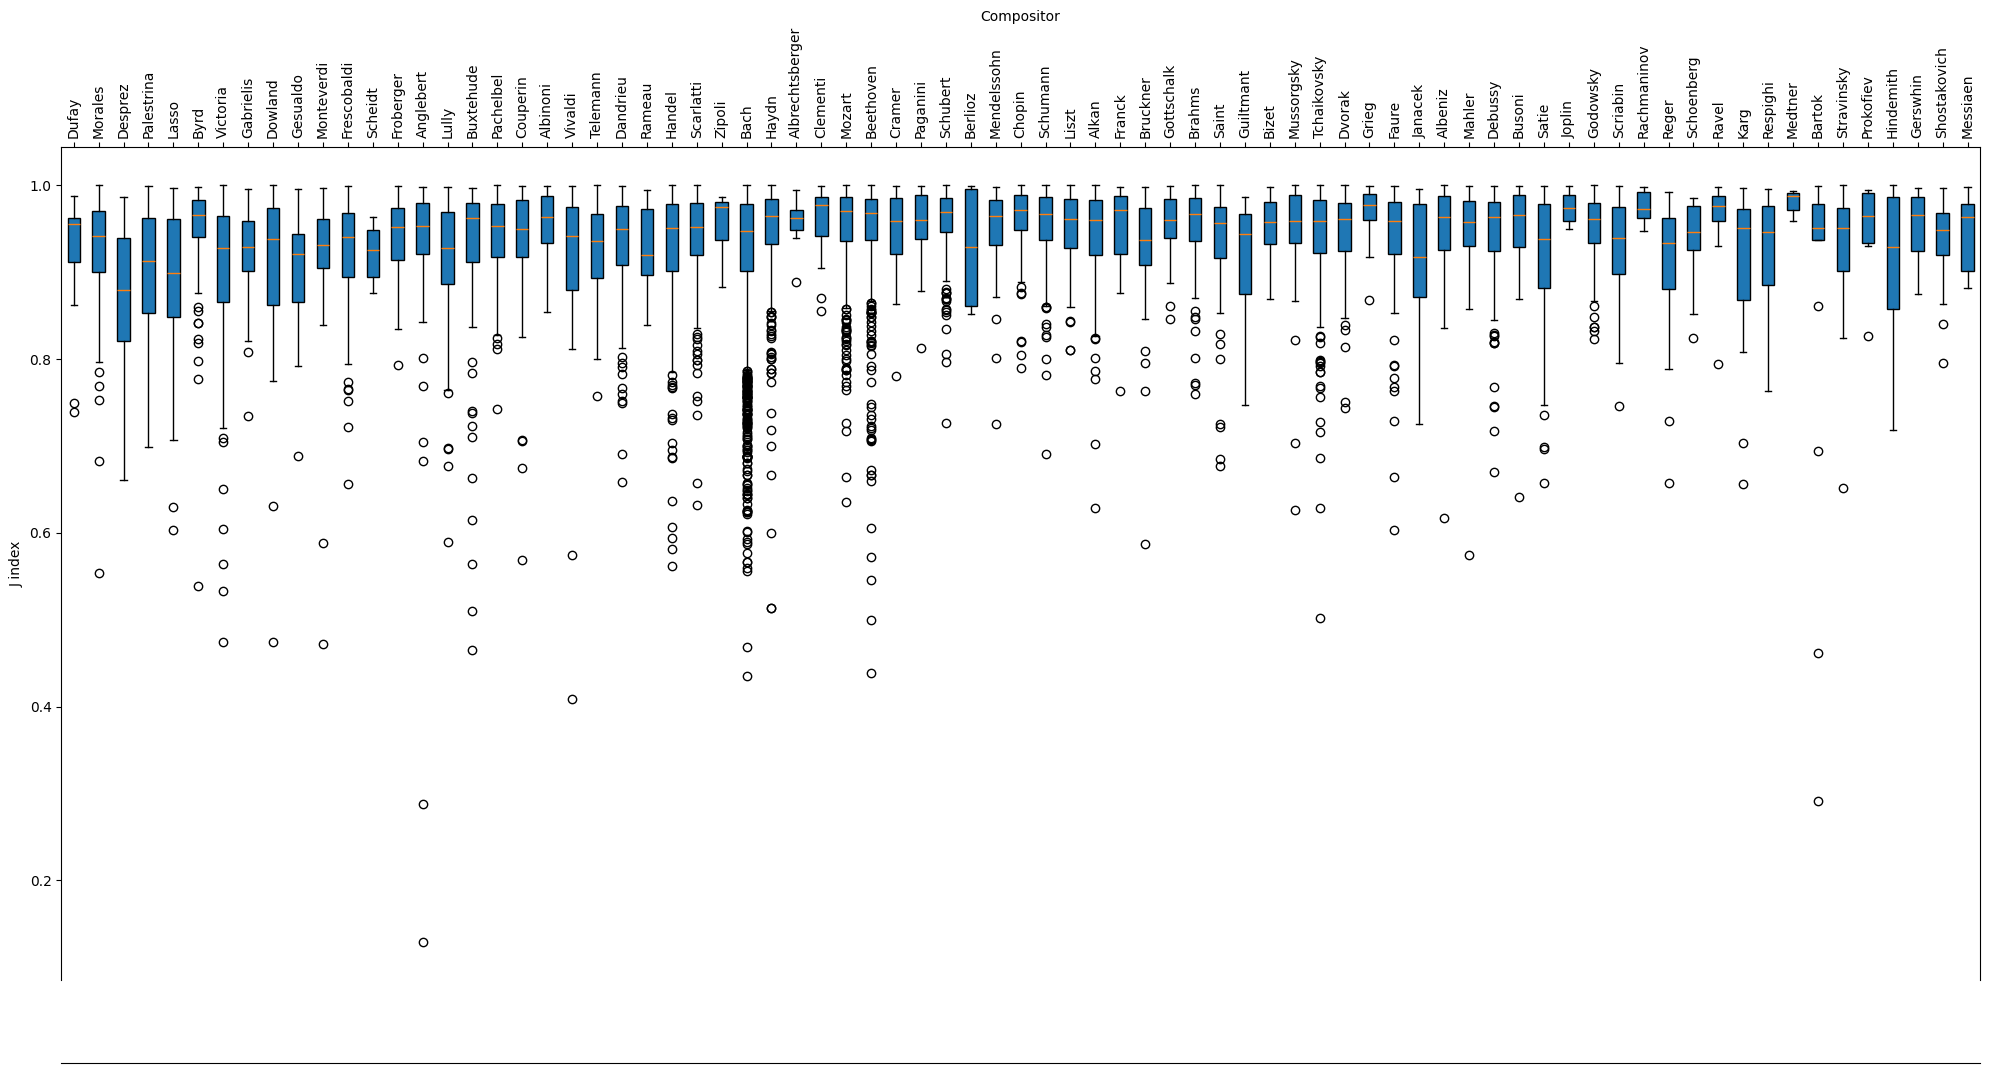

In [276]:
import numpy as np
import matplotlib.pyplot as plt


Js = np.load('J_composers.npy')
Ns = np.load('Ns.npy')
data = [Js[i,:datos_composers[composer]['# Piezas']] for i, composer in enumerate(datos_composers.keys())]


fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(data, patch_artist=True)


ax.set_xlabel('Compositor')
ax.set_ylabel('J index')
ax.set_xticks(np.arange(1, 78))  
ax.set_xticklabels([f'{composer}' for i, composer in enumerate(datos_composers.keys())], rotation=90)  # Rotar las etiquetas del eje x

ax.xaxis.set_label_position('top')  # Movemos la etiqueta del eje x
ax.xaxis.tick_top()  # Movemos los ticks del eje x a la parte superior
ax.spines['top'].set_position(('axes', 1.0))  # Movemos la espina superior al tope de la figura
ax.spines['bottom'].set_position(('axes', -0.1))  # Ocultamos la espina inferior

plt.setp(ax.get_xticklabels(), rotation=90, ha='center')


plt.tight_layout()


plt.show()

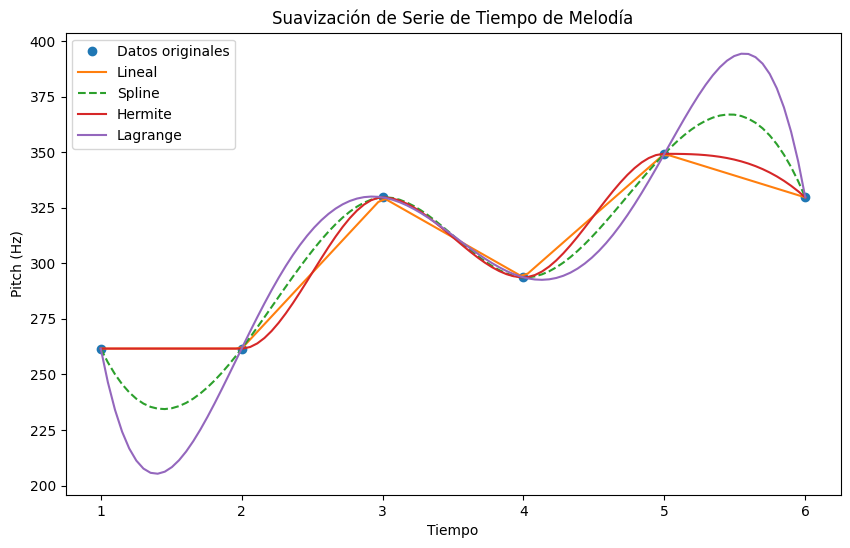

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from numpy.polynomial import Polynomial
from scipy.interpolate import lagrange
from scipy.interpolate import PchipInterpolator
from pykrige.ok import OrdinaryKriging


times = np.array([1, 2, 3, 4, 5, 6])
pitches = np.array([261.63, 261.63, 329.63, 293.66, 349.23, 329.63]) 

# Interpolacion Lineal
linear_interp = interp1d(times, pitches, kind='linear')

# Interpolacion Spline
spline_interp = CubicSpline(times, pitches)

# Interpolacion de Lagrange
lagrange_interp = lagrange(times, pitches)

#Interpolacion de Hermite
hermite_interp = PchipInterpolator(times, pitches)


# Generar puntos para graficar
fine_times = np.linspace(1, 6, 100)
linear_pitches = linear_interp(fine_times)
spline_pitches = spline_interp(fine_times)
lagrange_pitches = lagrange_interp(fine_times)
hermite_pitches = hermite_interp(fine_times)


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(times, pitches, 'o', label='Datos originales')
plt.plot(fine_times, linear_pitches, '-', label='Lineal')
plt.plot(fine_times, spline_pitches, '--', label='Spline')
plt.plot(fine_times, hermite_pitches, '-', label='Hermite')
plt.plot(fine_times, lagrange_pitches, label='Lagrange')
plt.xlabel('Tiempo')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.title('Suavización de Serie de Tiempo de Melodía')
plt.show()


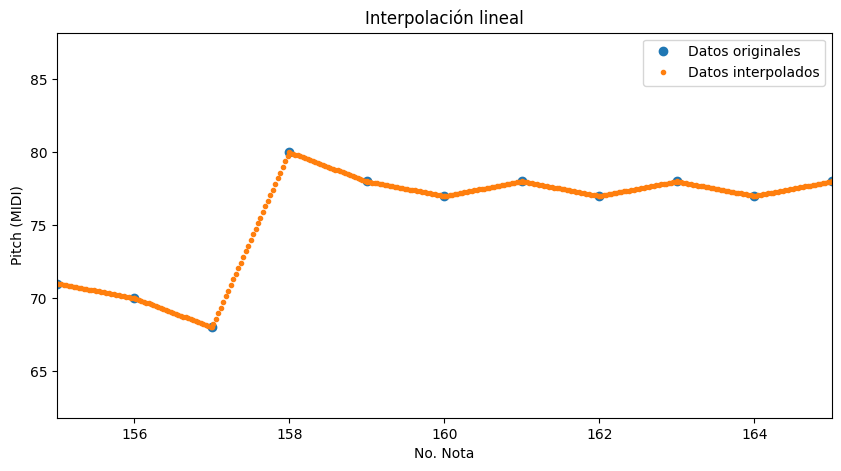

Original 322 0.8949907047199649
Interpolado 10318 0.46061098703466763


In [10]:
# Lineal
import numpy as np
import matplotlib.pyplot as plt


subject = composers['Bach']['Serie_10']
data = np.array([int(line.strip()) for line in subject.to_numpy()])


x = np.arange(len(data))


x_new = np.linspace(0, len(data) - 1, 10000)
x_new = np.unique(np.concatenate((x, x_new)))  


data_interp = np.interp(x_new, x, data)


plt.figure(figsize=(10, 5))
plt.plot(x, data, 'o', label='Datos originales')
plt.plot(x_new, data_interp, '.', label='Datos interpolados')
plt.legend()
plt.xlabel('No. Nota')
plt.xlim(155,165)
plt.ylabel('Pitch (MIDI)')
plt.title('Interpolación lineal')
plt.show()

J_subject = J_univariante(subject, int(len(subject)/2), len(subject))
print('Original',len(subject), J_subject)

J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
print('Interpolado', len(data_interp), J_interp)

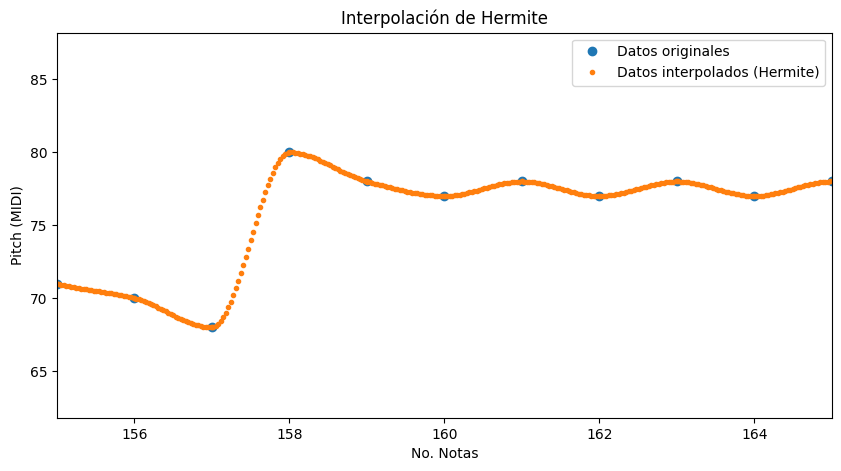

Original 322 0.8949907047199649
Interpolado 10318 0.20136739498649125


In [11]:
#Hermite (PCHIP)

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

subject = composers['Bach']['Serie_10']
data = np.array([int(line.strip()) for line in subject.to_numpy()])


x = np.arange(len(data))


x_new = np.linspace(0, len(data) - 1, 10000)
x_new = np.unique(np.concatenate((x, x_new)))  

interpolator = PchipInterpolator(x, data)
data_interp = interpolator(x_new)


plt.figure(figsize=(10, 5))
plt.plot(x, data, 'o', label='Datos originales')
plt.plot(x_new, data_interp, '.', label='Datos interpolados (Hermite)')
plt.legend()
plt.xlabel('No. Notas')
plt.xlim(155,165)
plt.ylabel('Pitch (MIDI)')
plt.title('Interpolación de Hermite')
plt.show()

J_subject = J_univariante(subject, int(len(subject)/2), len(subject))
print('Original',len(subject), J_subject)

J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
print('Interpolado', len(data_interp), J_interp)

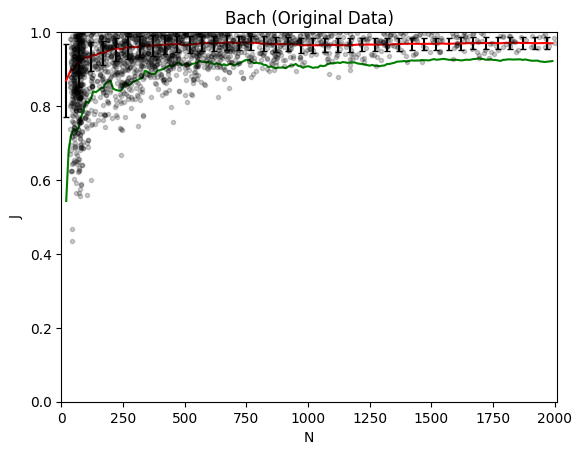

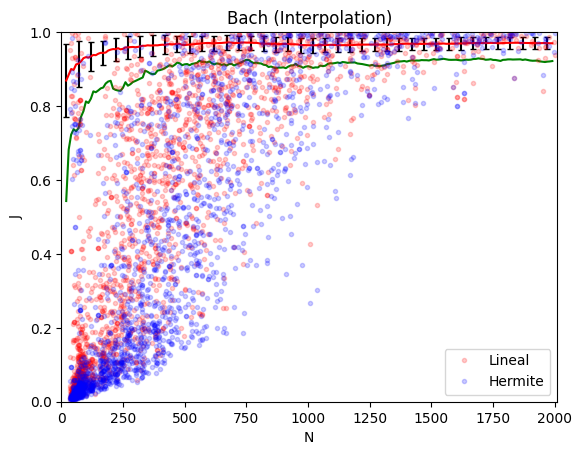

In [33]:
#Bach
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')
J_interp_bach_lineal = np.load('J_interp_bach_lineal.npy')
J_interp_bach_hermite = np.load('J_interp_bach_hermite.npy')

with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot(Ns[27,:], J_composers[27,:], '.', color = 'black',  alpha = 0.2)
plt.xlim(0, 2010)
plt.title('Bach (Original Data)')
plt.show()

with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot( Ns[27,:2159], J_interp_bach_lineal, '.', color = 'red', alpha = 0.2, label = 'Lineal')
plt.plot( Ns[27,:2159], J_interp_bach_hermite, '.', color = 'blue', alpha = 0.2, label = 'Hermite')
plt.legend()
plt.title('Bach (Interpolation)')
plt.xlim(0, 2010)
plt.show()
    
    

In [30]:
# Hermite bach
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')


################
# J_interp_bach_lineal = []
# for subject in composers['Bach'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     data_interp = np.interp(x_new, x, data)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_bach_lineal.append(J_interp)
# np.save('J_interp_bach_lineal.npy', J_interp_bach_lineal)
###################

# J_interp_bach_hermite = []
# for subject in composers['Bach'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     interpolator = PchipInterpolator(x, data)
#     data_interp = interpolator(x_new)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_bach_hermite.append(J_interp)
# np.save('J_interp_bach_hermite.npy', np.array(J_interp_bach_hermite))
#######################
    
    

In [18]:
datos_composers['Shostakovich']

{'Birth_year': '1906', '# Piezas': 109}

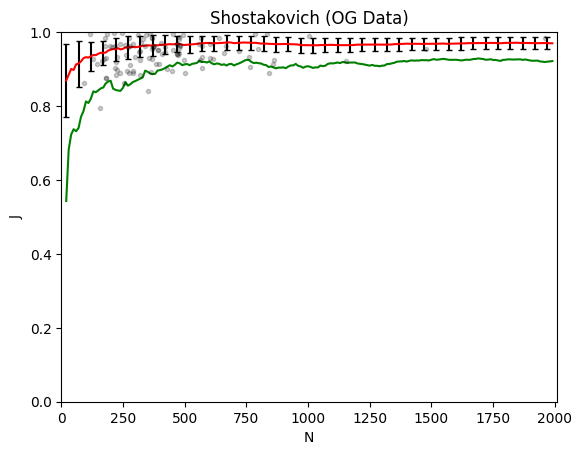

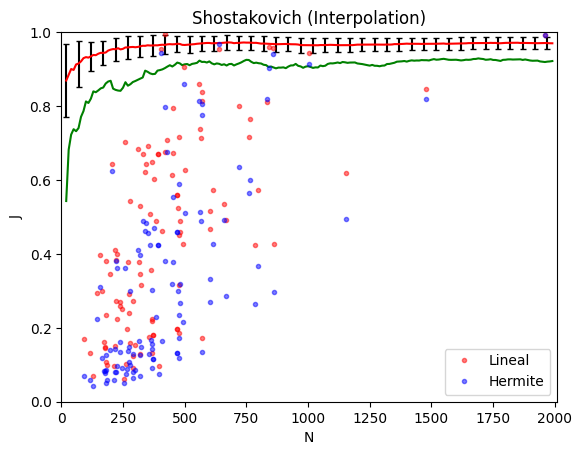

In [35]:
# Shostakovich
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')
J_interp_tako_lineal = np.load('J_interp_tako_lineal.npy')
J_interp_tako_hermite = np.load('J_interp_tako_hermite.npy')

with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot(Ns[75,:], J_composers[75,:], '.', color = 'black',  alpha = 0.2)
plt.title('Shostakovich (OG Data)')
plt.xlim(0, 2010)
plt.show()


with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot( Ns[75,:109] , J_interp_tako_lineal, '.', color = 'red', alpha = 0.5, label = 'Lineal')
plt.plot( Ns[75,:109] , J_interp_tako_hermite, '.', color = 'blue', alpha = 0.5, label = 'Hermite')
plt.title('Shostakovich (Interpolation)')
plt.legend()
plt.xlim(0, 2010)
plt.show()

In [31]:
# Hermite shostakovich
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')


###################
# J_interp_tako_lineal = []
# for subject in composers['Shostakovich'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     data_interp = np.interp(x_new, x, data)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_tako_lineal.append(J_interp)
# np.save('J_interp_tako_lineal.npy', np.array(J_interp_tako_lineal))
####################
# J_interp_tako_hermite = []

# for subject in composers['Shostakovich'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     interpolator = PchipInterpolator(x, data)
#     data_interp = interpolator(x_new)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_tako_hermite.append(J_interp)

# np.save('J_interp_tako_hermite.npy', np.array(J_interp_tako_hermite))

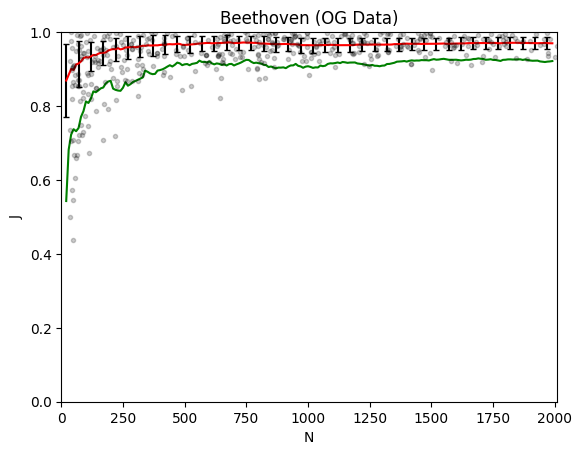

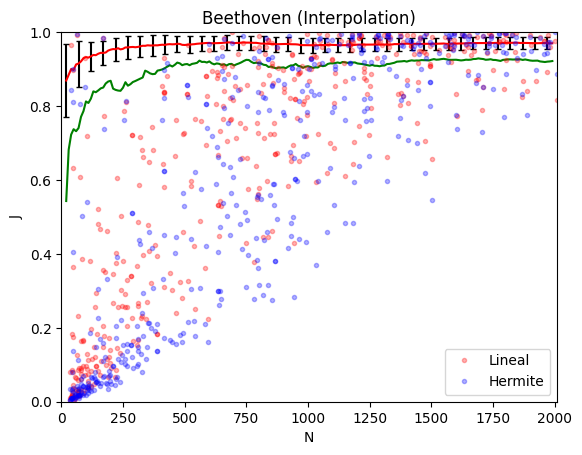

In [38]:
# Beethoven

import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')
J_interp_beth_lineal = np.load('J_interp_beth_lineal.npy')
J_interp_beth_hermite = np.load('J_interp_beth_hermite.npy')

with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot(Ns[32,:], J_composers[32,:], '.', color = 'black',  alpha = 0.2)
plt.title('Beethoven (OG Data)')
plt.xlim(0, 2010)
plt.show()


with open('j_null.pkl', 'rb') as f:
    fig = pickle.load(f)
plt.plot( Ns[32,:602], J_interp_beth_lineal, '.', color = 'red', alpha = 0.3, label = 'Lineal')
plt.plot( Ns[32,:602] , J_interp_beth_hermite, '.', color = 'blue', alpha = 0.3, label = 'Hermite')
plt.title('Beethoven (Interpolation)')
plt.legend()
plt.xlim(0, 2010)
plt.show()

In [36]:
# Compute beethoven
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

J_composers = np.load('J_composers.npy')
Ns = np.load('Ns.npy')

##################
# J_interp_beth_lineal = []

# for subject in composers['Beethoven'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     data_interp = np.interp(x_new, x, data)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_beth_lineal.append(J_interp)
# np.save('J_interp_beth_lineal.npy', np.array(J_interp_beth_lineal))
###################
# J_interp_beth_hermite = []

# for subject in composers['Beethoven'].values():
#     data = np.array([int(line.strip()) for line in subject.to_numpy()])

#     x = np.arange(len(data))

#     x_new = np.linspace(0, len(data) - 1, 10000)
#     x_new = np.unique(np.concatenate((x, x_new)))  

#     interpolator = PchipInterpolator(x, data)
#     data_interp = interpolator(x_new)

#     J_interp = J_univariante(data_interp, int(len(data_interp)/2), len(data_interp))
#     J_interp_beth_hermite.append(J_interp)
# np.save('J_interp_beth_hermite.npy', np.array(J_interp_beth_hermite))
